Procedure
------------

### Tricks
- adjust only 1-time user's previous deal prob with 0.5 weight


In [2]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import pickle
# print("Data:\n",os.listdir("../data"))

In [3]:
# In case we need to import the library directly
# import sys
# sys.path.append('/home/user/san/project_p/LightGBM/python-package/')

import lightgbm as lgb

In [4]:
# Models Packages
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn import feature_selection
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Gradient Boosting
import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold
from sklearn.model_selection import StratifiedKFold

# Tf-Idf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

# Viz
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string

%matplotlib inline

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
NFOLDS = 5
SEED = 42
VALID = True
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
        
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)
    
def cleanName(text):
    try:
        textProc = text.lower()
        # textProc = " ".join(map(str.strip, re.split('(\d+)',textProc)))
        #regex = re.compile(u'[^[:alpha:]]')
        #textProc = regex.sub(" ", textProc)
        textProc = re.sub('[!@#$_“”¨«»®´·º½¾¿¡§£₤‘’]', '', textProc)
        textProc = " ".join(textProc.split())
        return textProc
    except: 
        return "name error"
    
    
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

In [150]:
print("\nData Load Stage")
training = pd.read_csv('../data/train.csv', index_col = "item_id", parse_dates = ["activation_date"])
traindex = training.index
testing_set = pd.read_csv('../data/test.csv', index_col = "item_id", parse_dates = ["activation_date"])
testdex = testing_set.index


Data Load Stage


## Load prev deal prob feature

In [264]:
column_names = ['item_id', 'prev_deal_prob']

training_prev_deal_prob_45000 = pd.read_csv('../data/training_prev_deal_prob_45000.csv', header=None, names=column_names)
training_prev_deal_prob_90000 = pd.read_csv('../data/training_prev_deal_prob_90000.csv', header=None, names=column_names)
training_prev_deal_prob_135000 = pd.read_csv('../data/training_prev_deal_prob_135000.csv', header=None, names=column_names)
training_prev_deal_prob_180000 = pd.read_csv('../data/training_prev_deal_prob_180000.csv', header=None, names=column_names)
training_prev_deal_prob_240019 = pd.read_csv('../data/training_prev_deal_prob_240019.csv', header=None, names=column_names)

# testing_prev_deal_prob = pd.read_csv('../data/testing_prev_deal_prob.csv', header=None, names=column_names)

In [265]:
# Sanity Check
print(training_prev_deal_prob_45000.shape)
print(training_prev_deal_prob_90000.shape)
print(training_prev_deal_prob_135000.shape)
print(training_prev_deal_prob_180000.shape)
print(training_prev_deal_prob_240019.shape)

# print(testing_prev_deal_prob.shape)

(467331, 2)
(171025, 2)
(123280, 2)
(90000, 2)
(30276, 2)


In [266]:
training_prev_deal_prob_list = [training_prev_deal_prob_45000,
training_prev_deal_prob_90000,
training_prev_deal_prob_135000,
training_prev_deal_prob_180000,
training_prev_deal_prob_240019]

In [267]:
# concat all into one
training_prev_deal_prob = pd.concat(training_prev_deal_prob_list, axis=0)
training_prev_deal_prob.set_index("item_id", inplace=True)

In [280]:
training_prev_deal_prob.shape

(881912, 1)

In [281]:
training_prev_deal_prob.reset_index().item_id.nunique()

811136

In [301]:
training_prev_deal_prob = training_prev_deal_prob.reset_index()

In [304]:
# I don't know why too there are some duplicates...

training_prev_deal_prob.drop_duplicates(subset='item_id', inplace=True)

In [306]:
training_prev_deal_prob.item_id.nunique()

811136

In [308]:
training_prev_deal_prob.set_index('item_id', drop=True, inplace=True)

In [ ]:
# count dynamic mean for testing set

In [151]:
training.user_id

item_id
b912c3c6a6ad    e00f8ff2eaf9
2dac0150717d    39aeb48f0017
ba83aefab5dc    91e2f88dd6e3
02996f1dd2ea    bf5cccea572d
7c90be56d2ab    ef50846afc0b
51e0962387f7    bbfad0b1ad0a
c4f260a2b48a    08f469d2e6f7
6b71309d6a8a    fef86baa002c
c5b969cb63a2    055825270190
b1570962e68c    f9e8f831d94c
d5480bb4a6e4    d46200940f37
86f41f50d8c1    35c2b6b654e0
645237cb3601    fc9a38b79414
df2116f34563    3ce3c2318b16
a97943ae8158    f643d87dd23c
4b6abd0a5921    94de2b374869
7896ef8fe482    007c6bd858cb
7882b1e77748    7a3fda0cdf94
071e1ed13c5c    325cacee50f4
0658628930d4    27c2d83b766e
ea12aec32ec3    06ee4ff4e99c
838a82cec0a6    5d44315f6d90
de310e6aae86    0178e6308f38
08b24e170109    6630d724bbf5
065a4daba35f    19a5cd02c89b
990113ae4f1c    d9b494f97062
78164bc09657    721c2f914f63
fbe29970a8a5    2f0e2746d462
71d9399b59a2    965ee1e259eb
4941f0385575    d283308a713b
                    ...     
c346749a7127    6df435165550
3c073bb117d8    f3db5b0b12a1
6fcc0d49b22d    cd553840f1a2
f7cb51

In [83]:
user_more_1 = training[training.user_id.duplicated()].user_id.unique()
user_more_1_dpr = training[training.user_id.isin(user_more_1)].groupby('user_id')['deal_probability'].mean()

In [89]:
user_only_1_dpr = training[~training.user_id.isin(user_more_1)].groupby('user_id')['deal_probability'].mean()

In [94]:
# adjust only 1-time user's previous deal prob with 0.5 weight

user_only_1_dpr = user_only_1_dpr * 1/2

In [95]:
testing_prev_deal_prob_user = pd.concat([user_more_1_dpr, user_only_1_dpr], axis=0)

In [155]:
training.shape

(1503424, 17)

In [152]:
testing_prev_deal_prob_user

user_id
0000326c6042    0.000000
0000ae7a109b    0.000000
0000ba56add7    0.092233
000178adae29    0.062895
000185c6e01e    0.167210
00019abf543d    0.076569
0001ca77e128    0.073021
000251b32bdb    0.064345
0002939be10d    0.000000
0002bf213f29    0.021368
0002d67f8bd2    0.021265
00034b0f2ab7    0.024907
0003a7611778    0.054614
0003bc5f25a7    0.051476
0003ffe7300d    0.000000
00040fadaf1a    0.144202
000421762ce6    0.000000
00045fea2921    0.000000
0004c6d5ee91    0.000000
0005186094b0    0.372120
00051bc3d6f6    0.039665
00051c5a5f57    0.004732
00060ef3af27    0.000000
000633065eb4    0.111585
000639f15046    0.260725
000685fb0f02    0.000000
00068e1f86d9    0.000000
0006f59e4021    0.000000
000728c10af1    0.000000
000735c1bf63    0.000000
                  ...   
fffbea869447    0.000000
fffbf2e3231a    0.000000
fffc006e3ec7    0.106505
fffc1b3f2e7d    0.000000
fffc5a9f3f3a    0.000000
fffc98170fb4    0.000000
fffc99f823e4    0.000000
fffcdfea4a6f    0.156840
fffd1225e01d    0

In [157]:
testing_set.index

Index(['6544e41a8817', '65b9484d670f', '8bab230b2ecd', '8e348601fefc',
       '8bd2fe400b89', 'c63dbd6c657f', '6d1a410df86e', 'e8d3e7922b80',
       '2bc1ab208462', '7e05d77a9181',
       ...
       '0915772bb21c', 'd8984ced6639', 'e7c68be28a03', 'a96a4c5ad75a',
       'fdcd9910edf3', '9f2200aed300', '70813f518de4', 'a22a2eeb5dd2',
       'ed7fbb0733c1', 'd374d332992f'],
      dtype='object', name='item_id', length=508438)

In [170]:
df_testing_prev_deal_prob_user = testing_prev_deal_prob_user.to_frame().reset_index()

In [171]:
df_testing_prev_deal_prob_user.columns = ['user_id', 'prev_deal_prob']

In [172]:
df_testing_prev_deal_prob_user.head()

,user_id,prev_deal_prob
0,0000326c6042,0.000000
1,0000ae7a109b,0.000000
2,0000ba56add7,0.092233
3,000178adae29,0.062895
4,000185c6e01e,0.167210


In [175]:
sr_df_test_prev_dpr = testing_set.merge(df_testing_prev_deal_prob_user, on='user_id', how='left').set_index(testing_set.index)['prev_deal_prob']

In [176]:
sr_df_test_prev_dpr

item_id
6544e41a8817         NaN
65b9484d670f         NaN
8bab230b2ecd         NaN
8e348601fefc    0.000000
8bd2fe400b89         NaN
c63dbd6c657f         NaN
6d1a410df86e    0.094472
e8d3e7922b80    0.000000
2bc1ab208462    0.009452
7e05d77a9181         NaN
e2ec19a3ca2b    0.241931
68069bfc06c2    0.041125
595842ba248a         NaN
4130d5cfc5de         NaN
c21ede41b256    0.214742
f56e4684ceda         NaN
e7ab88d19965         NaN
81c1cd9f4e4e         NaN
2c989cea0e97         NaN
36a35020ebeb         NaN
60b0cc9cf25e    0.000000
ac0a01acccc2         NaN
683c444d6a40         NaN
5580ccd3358a         NaN
4596527723ec         NaN
2e414b752d9f         NaN
032e21134f2f         NaN
fd6f6a2ed415    0.011495
44da737c70af    0.000000
272e2ee33c62         NaN
                  ...   
df8001ca5897         NaN
0455281c86fb         NaN
482d3253c9f1         NaN
9278e7c14cd0    0.000000
9041d0340b49    0.034188
872c382ce446         NaN
67448ad8941c    0.383930
6ffaf4c20469         NaN
acc46dbda733     

### Finished taking Prev Deal Prob feat

## Sanity check for their deal prob

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56b00b0630>]],
      dtype=object)

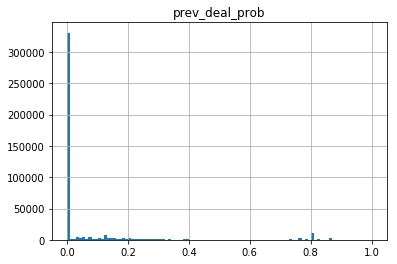

In [30]:
training_prev_deal_prob_45000.hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56b01de710>]],
      dtype=object)

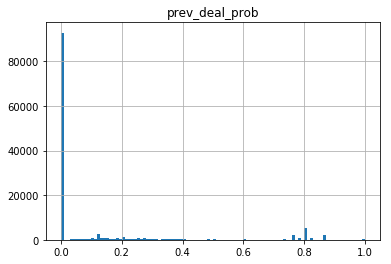

In [29]:
training_prev_deal_prob_90000.hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56b0320828>]],
      dtype=object)

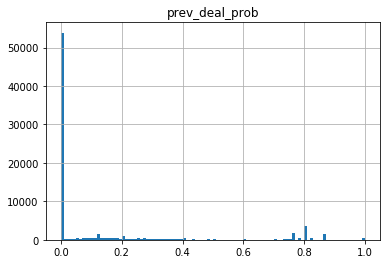

In [28]:
training_prev_deal_prob_135000.hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56aff6c0f0>]],
      dtype=object)

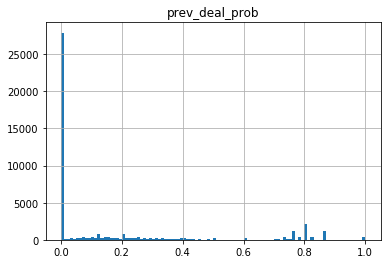

In [31]:
training_prev_deal_prob_180000.hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56afdab5c0>]],
      dtype=object)

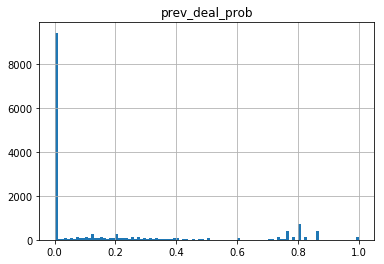

In [32]:
training_prev_deal_prob_240019.hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56c5cf9b00>]],
      dtype=object)

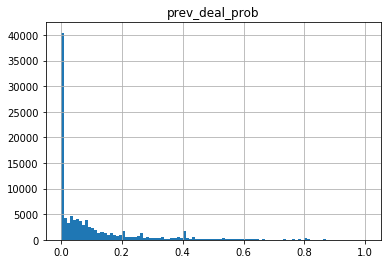

In [25]:
testing_prev_deal_prob.hist(bins=100)

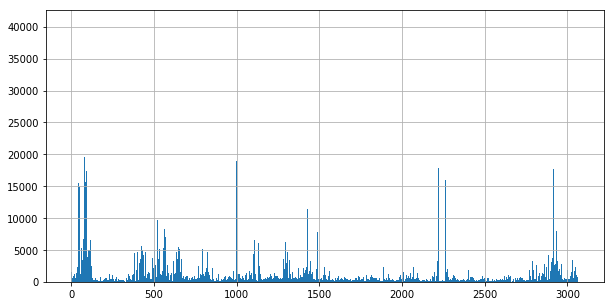

In [12]:
training.image_top_1.hist(bins=1000, figsize=(10,5))

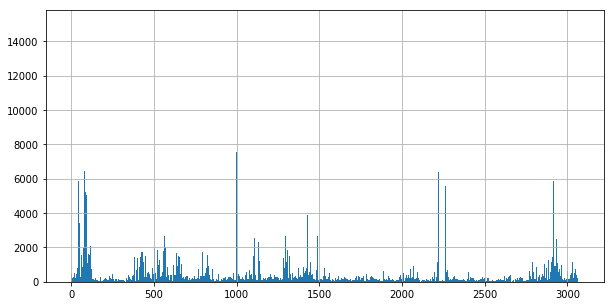

In [13]:
testing_set.image_top_1.hist(bins=1000, figsize=(10,5))

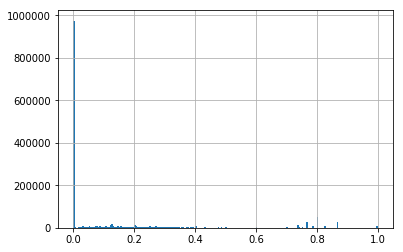

In [18]:
training.deal_probability.hist(bins=200)

In [ ]:
plt.scatter(range(len(training.image_top_1)), training.image_top_1, c=y)

In [ ]:
pd.scatter_matrix()

In [36]:
ntrain = training.shape[0]
ntest = testing.shape[0]

kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)
print('Train shape: {} Rows, {} Columns'.format(*training.shape))
print('Test shape: {} Rows, {} Columns'.format(*testing.shape))

print("Combine Train and Test")
df = pd.concat([training,testing],axis=0)
del training, testing
gc.collect()
print('\nAll Data shape: {} Rows, {} Columns'.format(*df.shape))

Train shape: 1503424 Rows, 16 Columns
Test shape: 508438 Rows, 16 Columns
Combine Train and Test

All Data shape: 2011862 Rows, 16 Columns


In [17]:
print("Feature Engineering")
df["price"] = np.log(df["price"]+0.001)
df["price"].fillna(df.price.mean(),inplace=True)
df["image_top_1"].fillna(-999,inplace=True)

print("\nCreate Time Variables")
df["Weekday"] = df['activation_date'].dt.weekday
df["Weekd of Year"] = df['activation_date'].dt.week
df["Day of Month"] = df['activation_date'].dt.day

# Create Validation Index and Remove Dead Variables
training_index = df.loc[df.activation_date<=pd.to_datetime('2017-04-07')].index
validation_index = df.loc[df.activation_date>=pd.to_datetime('2017-04-08')].index
df.drop(["activation_date"],axis=1,inplace=True)

print("\nEncode Variables")
categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]
print("Encoding :",categorical)

Feature Engineering

Create Time Variables

Encode Variables
Encoding : ['user_id', 'region', 'city', 'parent_category_name', 'category_name', 'user_type', 'image_top_1', 'param_1', 'param_2', 'param_3']


In [18]:
# Encoder:
lbl = preprocessing.LabelEncoder()
for col in categorical:
    df[col].fillna('Unknown')
    df[col] = lbl.fit_transform(df[col].astype(str))

In [2]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [19]:
print("\nText Features")

# Feature Engineering 

# Meta Text Features
textfeats = ["description", "title"]
df['desc_punc'] = df['description'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

df['title'] = df['title'].apply(lambda x: cleanName(x))
df["description"]   = df["description"].apply(lambda x: cleanName(x))

for cols in textfeats:
    df[cols] = df[cols].astype(str) 
    df[cols] = df[cols].astype(str).fillna('missing') # FILL NA
    df[cols] = df[cols].str.lower() # Lowercase all text, so that capitalized words dont get treated differently
    df[cols + '_num_words'] = df[cols].apply(lambda comment: len(comment.split())) # Count number of Words
    df[cols + '_num_unique_words'] = df[cols].apply(lambda comment: len(set(w for w in comment.split())))
    df[cols + '_words_vs_unique'] = df[cols+'_num_unique_words'] / df[cols+'_num_words'] * 100 # Count Unique Words
    

print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}


Text Features

[TF-IDF] Term Frequency Inverse Document Frequency Stage


In [9]:
def get_col(col_name): return lambda x: x[col_name]
##I added to the max_features of the description. It did not change my score much but it may be worth investigating
vectorizer = FeatureUnion([
        ('description',TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=17000,
            **tfidf_para,
            preprocessor=get_col('description'))),
        ('title',CountVectorizer(
            ngram_range=(1, 2),
            stop_words = russian_stop,
            #max_features=7000,
            preprocessor=get_col('title')))
    ])


In [10]:
start_vect=time.time()

#Fit my vectorizer on the entire dataset instead of the training rows
#Score improved by .0001
vectorizer.fit(df.to_dict('records'))

ready_df = vectorizer.transform(df.to_dict('records'))
tfvocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

# Drop Text Cols
textfeats = ["description", "title"]
df.drop(textfeats, axis=1,inplace=True)

Vectorization Runtime: 10.02 Minutes


In [11]:
from sklearn.metrics import mean_squared_error
from math import sqrt

ridge_params = {'alpha':30.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':SEED}

#Ridge oof method from Faron's kernel
#I was using this to analyze my vectorization, but figured it would be interesting to add the results back into the dataset
#It doesn't really add much to the score, but it does help lightgbm converge faster
ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params)
ridge_oof_train, ridge_oof_test = get_oof(ridge, ready_df[:ntrain], y, ready_df[ntrain:])

rms = sqrt(mean_squared_error(y, ridge_oof_train))
print('Ridge OOF RMSE: {}'.format(rms))


Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Ridge OOF RMSE: 0.23034390282097936


In [12]:
print("Modeling Stage")

ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])

df['ridge_preds'] = ridge_preds

Modeling Stage


## Save ready_df and df

In [ ]:
# from scipy import sparse

# sparse.save_npz('/media/data/avito/preprocessed/ready_df_02222.hdf', ready_df)

# df.to_hdf('/media/data/avito/preprocessed/df_02222.hdf', key='table')

# import pickle

# with open('/media/data/avito/preprocessed/traindex.pkl', 'wb') as file_output:
#     pickle.dump(traindex, file_output, protocol=pickle.HIGHEST_PROTOCOL)
    
# with open('/media/data/avito/preprocessed/testdex.pkl', 'wb') as file_output:
#     pickle.dump(testdex, file_output, protocol=pickle.HIGHEST_PROTOCOL)

## Load read_df, df, traindex, testdex & tfvocab

In [309]:
from scipy import sparse

## The SVD TFIDF
# ready_df = np.load('..data/ready_df_svd.npy')

## Original TFIDF
ready_df = sparse.load_npz("../data/ready_df_02222.hdf.npz")

df = pd.read_hdf('../data/df_02222.hdf', key='table')

with open('../data/traindex.pkl', 'rb') as file_output:
    traindex = pickle.load(file_output)
with open('../data/testdex.pkl', 'rb') as file_output:
    testdex = pickle.load(file_output)
with open('../data/df_tfvocab_pub_ker.pkl', 'rb') as file_output:
    tfvocab = pickle.load(file_output)
    
y = pd.read_hdf('../data/y.hdf', key='table')

## load image features

categorical = ["user_id","region","city","parent_category_name","category_name","user_type","image_top_1","param_1","param_2","param_3"]

In [312]:
#### Adding trianing's Prev deal prob into df 
df = df.merge(training_prev_deal_prob, how='left', left_index=True, right_index=True).set_index(df.index)
print(df.shape)

df_testing_prev_deal_prob_user = testing_prev_deal_prob_user.to_frame().reset_index()
print(df.shape)

df = df.merge(sr_df_test_prev_dpr.to_frame(), how='left', left_index=True, right_index=True)
print(df.shape)

df['prev_deal_prob'] = df.prev_deal_prob_x.combine_first(df.prev_deal_prob_y)

(2011862, 25)
(2011862, 25)
(2011862, 26)


In [313]:
df_train_img_feat = pd.read_hdf('../data/df_train_img_feat.hdf', key='table')
df_test_img_feat = pd.read_hdf('../data/df_test_img_feat.hdf', key='table')

print("Image Feature: Combine Train and Test")
df_img_feat = pd.concat([df_train_img_feat,df_test_img_feat], axis=0)
print(df_img_feat.shape)

# Add .jpg
df.image = df.image + '.jpg'

# Review added .jpg
# print(df.image[0])
print(df.image.iloc[1])

df = df.reset_index().merge(df_img_feat, on='image', how="left").set_index(df.index.names)
print(df.shape)

# del df_train_img_feat; del df_test_img_feat; del df_img_feat

Image Feature: Combine Train and Test
(1856661, 9)
79c9392cc51a9c81c6eb91eceb8e552171db39d71427001e1e0859c0fb843a31.jpg
(2011862, 35)


In [314]:
# Pong's feature

with open('../data/df_pong.pkl', 'rb') as file_output:
    df_pong = pickle.load(file_output)

useful_list_from_pong = ['category_name_one_ratio',
                         'category_name_zero_ratio',
                         'category_name_score_lower_extreme',
                        'category_name_score_upper_extreme',
                            'city_one_ratio',
                             'city_zero_ratio',
                             'image_top_1_one_ratio',
                             'image_top_1_zero_ratio',
                         'param_1_one_ratio', 
                           'param_1_score_lower_extreme',
                         'param_1_score_upper_extreme',
                           'param_1_zero_ratio',  'param_1_score',
                         'param_2_one_ratio',
                         'param_2_score_lower_extreme','param_2_score_upper_extreme',
                         'param_2_zero_ratio',  'param_2_score',
                       'param_3_one_ratio', 'param_3_score',
                       'param_3_score_lower_extreme', 'param_3_score_upper_extreme',
                        'param_3_zero_ratio',
        'region_one_ratio', 'region_zero_ratio', 
     'user_type_one_ratio','user_type_zero_ratio']

df_pong_useful = df_pong[useful_list_from_pong]

In [315]:
df = df.merge(df_pong_useful, how='left', right_index=True, left_index=True).set_index(df.index)

In [316]:
# remove useless features

df.drop(['image', 'Weekd of Year', 'Day of Month', 'prev_deal_prob_x', 'prev_deal_prob_y'], axis=1, inplace=True)

In [317]:
df.prev_deal_prob.describe()

count    795347.000000
mean          0.092915
std           0.209855
min           0.000000
25%           0.000000
50%           0.000000
75%           0.066430
max           1.000000
Name: prev_deal_prob, dtype: float64

In [318]:
ready_df.shape

(2011862, 1430760)

In [319]:
df.shape

(2011862, 57)

In [320]:
# Combine Dense Features with Sparse Text Bag of Words Features
X = hstack([csr_matrix(df.loc[traindex,:].values),ready_df[0:traindex.shape[0]]]) # Sparse Matrix
testing = hstack([csr_matrix(df.loc[testdex,:].values),ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + tfvocab
for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
# del df
gc.collect();

print("\nModeling Stage")

del ready_df
gc.collect();

1503424 Rows and 1430817 Cols
508438 Rows and 1430817 Cols
Feature Names Length:  1430817

Modeling Stage


In [321]:
# pd.options.display.max_rows=120
# y.describe(percentiles=np.arange(0.1,1,0.01))

y_4_bins = pd.cut(y,[-0.01,0.01,0.163, 0.76, 1], labels=['0', '0.01', '0.163', '0.76'], right=True) 

# y_4_bins.unique()

In [322]:
y.head()

item_id
b912c3c6a6ad    0.12789
2dac0150717d    0.00000
ba83aefab5dc    0.43177
02996f1dd2ea    0.80323
7c90be56d2ab    0.20797
Name: deal_probability, dtype: float64


# Create K fold (stratified)

In [323]:
X = X.tocsr()
testing = testing.tocsr()

Light Gradient Boosting Regressor
strat kf starting... 5
StratifiedKFold(n_splits=5, random_state=135, shuffle=True)
starting Fold:  1 1202737 300687


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.251044	valid's rmse: 0.251368
[20]	train's rmse: 0.243585	valid's rmse: 0.244298
[30]	train's rmse: 0.238038	valid's rmse: 0.239071
[40]	train's rmse: 0.233679	valid's rmse: 0.235022
[50]	train's rmse: 0.230033	valid's rmse: 0.231766
[60]	train's rmse: 0.227074	valid's rmse: 0.229215
[70]	train's rmse: 0.224671	valid's rmse: 0.227208
[80]	train's rmse: 0.222815	valid's rmse: 0.225692
[90]	train's rmse: 0.221318	valid's rmse: 0.224494
[100]	train's rmse: 0.219936	valid's rmse: 0.223528
[110]	train's rmse: 0.218806	valid's rmse: 0.222744
[120]	train's rmse: 0.217857	valid's rmse: 0.222124
[130]	train's rmse: 0.216961	valid's rmse: 0.221605
[140]	train's rmse: 0.216176	valid's rmse: 0.221174
[150]	train's rmse: 0.215448	valid's rmse: 0.220817
[160]	train's rmse: 0.214768	valid's rmse: 0.220505
[170]	train's rmse: 0.214095	valid's rmse: 0.220231
[180]	train's rmse: 0.213553	valid's rmse: 0.220008
[190]	train

[1570]	train's rmse: 0.186419	valid's rmse: 0.216748
[1580]	train's rmse: 0.186293	valid's rmse: 0.216745
[1590]	train's rmse: 0.186173	valid's rmse: 0.216745
[1600]	train's rmse: 0.186059	valid's rmse: 0.216748
[1610]	train's rmse: 0.185948	valid's rmse: 0.21675
[1620]	train's rmse: 0.185822	valid's rmse: 0.216748
[1630]	train's rmse: 0.185702	valid's rmse: 0.216748
Early stopping, best iteration is:
[1585]	train's rmse: 0.186234	valid's rmse: 0.216744


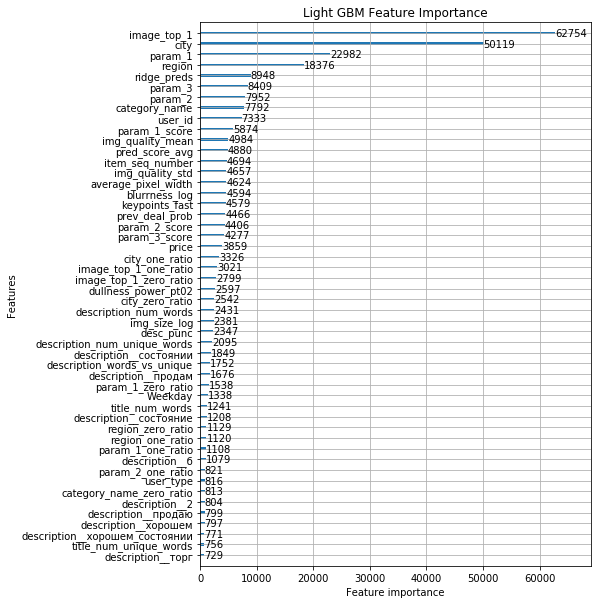

Model Evaluation Stage - Test set prediction...
=== Finished Fold 1 ===
starting Fold:  2 1202737 300687


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.250977	valid's rmse: 0.251396
[20]	train's rmse: 0.243691	valid's rmse: 0.244418
[30]	train's rmse: 0.238131	valid's rmse: 0.239119
[40]	train's rmse: 0.233603	valid's rmse: 0.234895
[50]	train's rmse: 0.230036	valid's rmse: 0.231688
[60]	train's rmse: 0.227218	valid's rmse: 0.22921
[70]	train's rmse: 0.224955	valid's rmse: 0.227254
[80]	train's rmse: 0.222982	valid's rmse: 0.225678
[90]	train's rmse: 0.221351	valid's rmse: 0.22442
[100]	train's rmse: 0.219988	valid's rmse: 0.223411
[110]	train's rmse: 0.218839	valid's rmse: 0.222607
[120]	train's rmse: 0.217832	valid's rmse: 0.221977
[130]	train's rmse: 0.216954	valid's rmse: 0.221442
[140]	train's rmse: 0.21615	valid's rmse: 0.221013
[150]	train's rmse: 0.21543	valid's rmse: 0.220648
[160]	train's rmse: 0.214774	valid's rmse: 0.220363
[170]	train's rmse: 0.214143	valid's rmse: 0.220119
[180]	train's rmse: 0.213625	valid's rmse: 0.219906
[190]	train's r

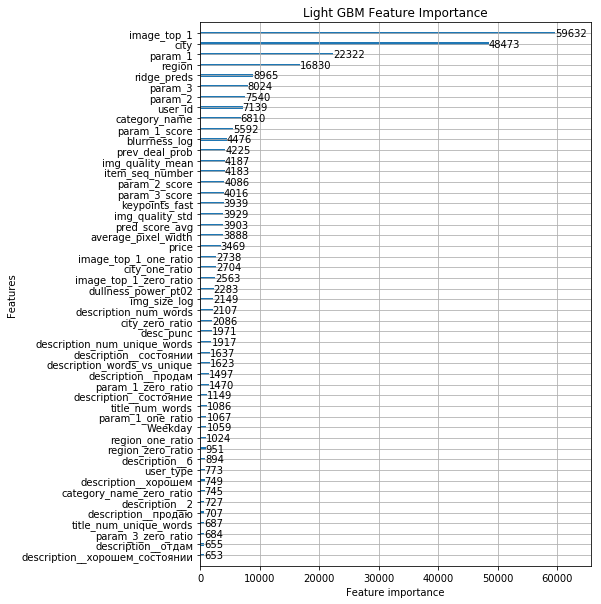

Model Evaluation Stage - Test set prediction...
=== Finished Fold 2 ===
starting Fold:  3 1202740 300684


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.250997	valid's rmse: 0.251247
[20]	train's rmse: 0.243852	valid's rmse: 0.244261
[30]	train's rmse: 0.238276	valid's rmse: 0.238906
[40]	train's rmse: 0.233842	valid's rmse: 0.234727
[50]	train's rmse: 0.230285	valid's rmse: 0.2314
[60]	train's rmse: 0.227318	valid's rmse: 0.22873
[70]	train's rmse: 0.224894	valid's rmse: 0.226683
[80]	train's rmse: 0.222906	valid's rmse: 0.225048
[90]	train's rmse: 0.22134	valid's rmse: 0.223795
[100]	train's rmse: 0.220031	valid's rmse: 0.222801
[110]	train's rmse: 0.21885	valid's rmse: 0.221956
[120]	train's rmse: 0.217893	valid's rmse: 0.22129
[130]	train's rmse: 0.216992	valid's rmse: 0.220752
[140]	train's rmse: 0.216226	valid's rmse: 0.220291
[150]	train's rmse: 0.215523	valid's rmse: 0.219918
[160]	train's rmse: 0.214885	valid's rmse: 0.219584
[170]	train's rmse: 0.214236	valid's rmse: 0.219314
[180]	train's rmse: 0.213663	valid's rmse: 0.219083
[190]	train's rms

[1580]	train's rmse: 0.186488	valid's rmse: 0.215817
[1590]	train's rmse: 0.186356	valid's rmse: 0.215814
[1600]	train's rmse: 0.18623	valid's rmse: 0.215811
[1610]	train's rmse: 0.186103	valid's rmse: 0.215808
[1620]	train's rmse: 0.185988	valid's rmse: 0.215809
[1630]	train's rmse: 0.185865	valid's rmse: 0.215808
[1640]	train's rmse: 0.185743	valid's rmse: 0.215808
[1650]	train's rmse: 0.185618	valid's rmse: 0.215806
[1660]	train's rmse: 0.185495	valid's rmse: 0.215804
[1670]	train's rmse: 0.185379	valid's rmse: 0.215801
[1680]	train's rmse: 0.185258	valid's rmse: 0.215798
[1690]	train's rmse: 0.18513	valid's rmse: 0.215798
[1700]	train's rmse: 0.18501	valid's rmse: 0.215798
[1710]	train's rmse: 0.184885	valid's rmse: 0.215798
[1720]	train's rmse: 0.184767	valid's rmse: 0.215796
[1730]	train's rmse: 0.184658	valid's rmse: 0.215793
[1740]	train's rmse: 0.184533	valid's rmse: 0.215789
[1750]	train's rmse: 0.184408	valid's rmse: 0.215787
[1760]	train's rmse: 0.18429	valid's rmse: 0.2157

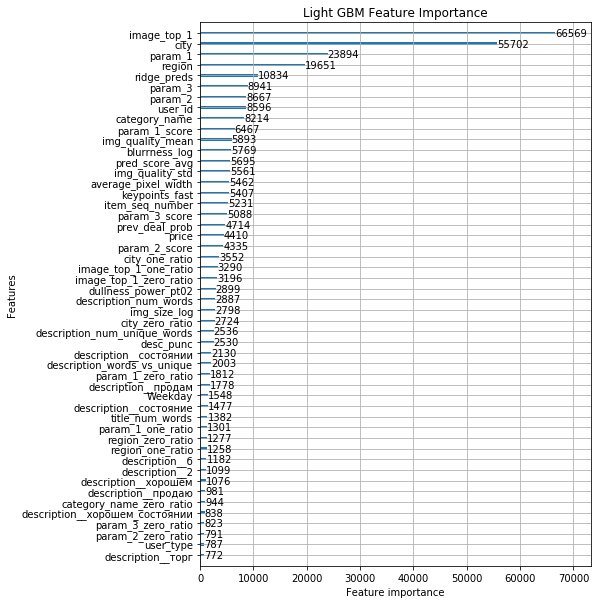

Model Evaluation Stage - Test set prediction...
=== Finished Fold 3 ===
starting Fold:  4 1202741 300683


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.250818	valid's rmse: 0.251086
[20]	train's rmse: 0.243869	valid's rmse: 0.244398
[30]	train's rmse: 0.238201	valid's rmse: 0.239069
[40]	train's rmse: 0.233725	valid's rmse: 0.234922
[50]	train's rmse: 0.230132	valid's rmse: 0.23164
[60]	train's rmse: 0.227148	valid's rmse: 0.229093
[70]	train's rmse: 0.224838	valid's rmse: 0.227116
[80]	train's rmse: 0.222933	valid's rmse: 0.225583
[90]	train's rmse: 0.221325	valid's rmse: 0.224371
[100]	train's rmse: 0.219988	valid's rmse: 0.223384
[110]	train's rmse: 0.218779	valid's rmse: 0.222577
[120]	train's rmse: 0.217763	valid's rmse: 0.221949
[130]	train's rmse: 0.216922	valid's rmse: 0.221402
[140]	train's rmse: 0.216199	valid's rmse: 0.22097
[150]	train's rmse: 0.215466	valid's rmse: 0.220585
[160]	train's rmse: 0.21483	valid's rmse: 0.220262
[170]	train's rmse: 0.214206	valid's rmse: 0.220005
[180]	train's rmse: 0.213602	valid's rmse: 0.219765
[190]	train's 

[1580]	train's rmse: 0.186229	valid's rmse: 0.216486
[1590]	train's rmse: 0.186103	valid's rmse: 0.216484
[1600]	train's rmse: 0.185987	valid's rmse: 0.216483
[1610]	train's rmse: 0.18588	valid's rmse: 0.216484
[1620]	train's rmse: 0.185768	valid's rmse: 0.216479
[1630]	train's rmse: 0.185654	valid's rmse: 0.216478
[1640]	train's rmse: 0.185529	valid's rmse: 0.216475
[1650]	train's rmse: 0.185405	valid's rmse: 0.216475
[1660]	train's rmse: 0.185293	valid's rmse: 0.216471
[1670]	train's rmse: 0.185177	valid's rmse: 0.216467
[1680]	train's rmse: 0.185057	valid's rmse: 0.216468
[1690]	train's rmse: 0.184946	valid's rmse: 0.216466
[1700]	train's rmse: 0.184831	valid's rmse: 0.216463
[1710]	train's rmse: 0.18471	valid's rmse: 0.216456
[1720]	train's rmse: 0.184587	valid's rmse: 0.216451
[1730]	train's rmse: 0.184457	valid's rmse: 0.21645
[1740]	train's rmse: 0.184336	valid's rmse: 0.216448
[1750]	train's rmse: 0.184215	valid's rmse: 0.216449
[1760]	train's rmse: 0.184104	valid's rmse: 0.216

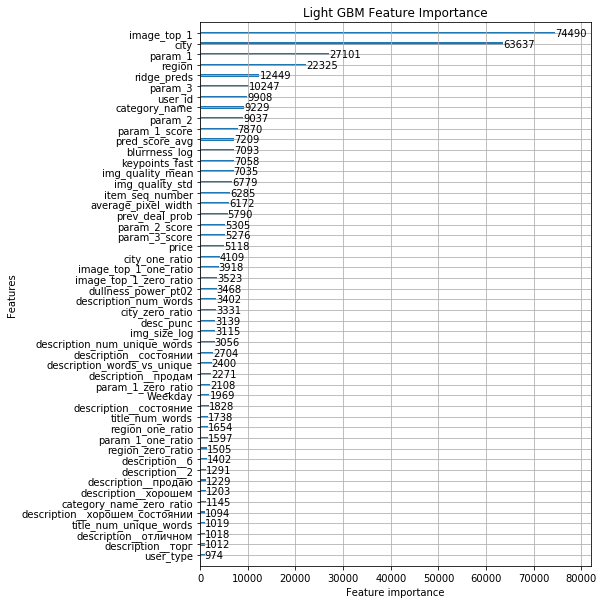

Model Evaluation Stage - Test set prediction...
=== Finished Fold 4 ===
starting Fold:  5 1202741 300683


/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/home/ubuntu/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[10]	train's rmse: 0.250777	valid's rmse: 0.250789
[20]	train's rmse: 0.243762	valid's rmse: 0.244082
[30]	train's rmse: 0.237931	valid's rmse: 0.238593
[40]	train's rmse: 0.23355	valid's rmse: 0.23452
[50]	train's rmse: 0.23001	valid's rmse: 0.23132
[60]	train's rmse: 0.227165	valid's rmse: 0.22883
[70]	train's rmse: 0.224952	valid's rmse: 0.226924
[80]	train's rmse: 0.223029	valid's rmse: 0.225351
[90]	train's rmse: 0.221329	valid's rmse: 0.224039
[100]	train's rmse: 0.219948	valid's rmse: 0.223056
[110]	train's rmse: 0.218799	valid's rmse: 0.222283
[120]	train's rmse: 0.217744	valid's rmse: 0.221629
[130]	train's rmse: 0.21684	valid's rmse: 0.221102
[140]	train's rmse: 0.216096	valid's rmse: 0.220678
[150]	train's rmse: 0.215392	valid's rmse: 0.220306
[160]	train's rmse: 0.214691	valid's rmse: 0.219997
[170]	train's rmse: 0.214126	valid's rmse: 0.219719
[180]	train's rmse: 0.213541	valid's rmse: 0.219493
[190]	train's rms

[1580]	train's rmse: 0.18636	valid's rmse: 0.216267
[1590]	train's rmse: 0.186235	valid's rmse: 0.216264
[1600]	train's rmse: 0.186111	valid's rmse: 0.216264
[1610]	train's rmse: 0.185987	valid's rmse: 0.216262
[1620]	train's rmse: 0.185858	valid's rmse: 0.21626
[1630]	train's rmse: 0.18575	valid's rmse: 0.216261
[1640]	train's rmse: 0.185631	valid's rmse: 0.216261
[1650]	train's rmse: 0.185513	valid's rmse: 0.216259
[1660]	train's rmse: 0.185403	valid's rmse: 0.216255
[1670]	train's rmse: 0.185283	valid's rmse: 0.216255
[1680]	train's rmse: 0.18517	valid's rmse: 0.216258
[1690]	train's rmse: 0.185051	valid's rmse: 0.216253
[1700]	train's rmse: 0.184931	valid's rmse: 0.216253
[1710]	train's rmse: 0.184803	valid's rmse: 0.21625
[1720]	train's rmse: 0.184692	valid's rmse: 0.216252
[1730]	train's rmse: 0.184583	valid's rmse: 0.21625
[1740]	train's rmse: 0.184465	valid's rmse: 0.216249
[1750]	train's rmse: 0.184346	valid's rmse: 0.21625
[1760]	train's rmse: 0.184233	valid's rmse: 0.21625
[

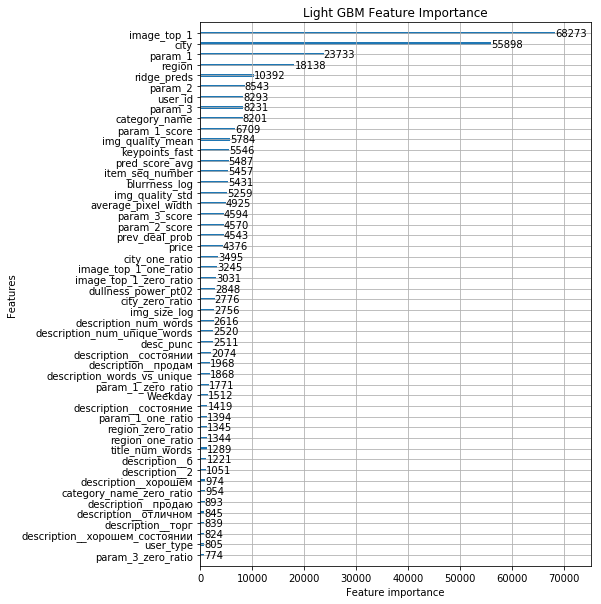

Model Evaluation Stage - Test set prediction...
=== Finished Fold 5 ===
CPU times: user 2d 1h 51min 20s, sys: 14h 16min 23s, total: 2d 16h 7min 44s
Wall time: 1h 55min 1s


In [326]:
%%time
print("Light Gradient Boosting Regressor")

lgbm_params =  {
#     'device': 'gpu',
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    # 'max_depth': 15,
    'num_leaves': 300, ### 270
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.016,
    'verbose': 1
}  

NFOLDS = 5
SEED = 135

strat_kf = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
print('strat kf starting...', strat_kf.get_n_splits(X, y_4_bins))
print(strat_kf)

for i, (train_index, test_index) in enumerate(strat_kf.split(X, y_4_bins)):
    print('starting Fold: ', i+1, len(train_index), len(test_index))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    
    lgtrain = lgb.Dataset(X_train, y_train,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    lgvalid = lgb.Dataset(X_valid, y_valid,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
#     del X, X_train; gc.collect()
    
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=10000,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=50, ### 150 ### 50
        verbose_eval=10)
    
    # Print importance
    f, ax = plt.subplots(figsize=[7,10])
    lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
    plt.title("Light GBM Feature Importance")
    plt.show()
    
    print("Model Evaluation Stage - Test set prediction...")
    lgpred = lgb_clf.predict(testing) 

    #Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
    #blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
    lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
    lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
    lgsub.to_csv("lgsub_ALL_FEAT_fold_{}.csv".format(i),index=True,header=True)
    print('=== Finished Fold {} ==='.format(i+1))
    

In [328]:
result0 = pd.read_csv('lgsub_ALL_FEAT_fold_0.csv', index_col = "item_id")
result1 = pd.read_csv('lgsub_ALL_FEAT_fold_1.csv', index_col = "item_id")
result2 = pd.read_csv('lgsub_ALL_FEAT_fold_2.csv', index_col = "item_id")
result3 = pd.read_csv('lgsub_ALL_FEAT_fold_3.csv', index_col = "item_id")
result4 = pd.read_csv('lgsub_ALL_FEAT_fold_4.csv', index_col = "item_id")

In [329]:
result_all = (result0 + result1 + result2 + result3 + result4)/5

In [330]:
result_all.to_csv("lgsub_ALL_FEAT_w_5_fold.csv",index=True,header=True)

best_public_blend = pd.read_csv('lgsub_best_public_blend_2204.csv', index_col = "item_id")

blend_4_ultimate = (best_public_blend + result_all) /2

blend_4_ultimate.to_csv('lgsub_blend_4_ultimate.csv',index=True,header=True )

In [ ]:
## blend with cluster

In [5]:
result0 = pd.read_csv('lgsub_cluster_1_fold_1.csv')
result1 = pd.read_csv('lgsub_cluster_1_fold_2.csv')
result2 = pd.read_csv('lgsub_cluster_1_fold_3.csv')
result3 = pd.read_csv('lgsub_cluster_1_fold_4.csv')
result4 = pd.read_csv('lgsub_cluster_1_fold_5.csv')

In [12]:
result0.set_index('Unnamed: 0', inplace=True)
result1.set_index('Unnamed: 0', inplace=True)
result2.set_index('Unnamed: 0', inplace=True)
result3.set_index('Unnamed: 0', inplace=True)
result4.set_index('Unnamed: 0', inplace=True)

In [13]:
result0.head()

,deal_probability
Unnamed: 0,
6544e41a8817,0.269332
e8d3e7922b80,0.030277
4130d5cfc5de,0.138875
e7ab88d19965,0.192488
2c989cea0e97,0.063945


In [14]:
result_all = (result0 + result1 + result2 + result3 + result4)/5

In [15]:
result_all.index.name = 'item_id'

In [34]:
blend_4_ultimate = pd.read_csv('lgsub_blend_4_ultimate.csv', index_col = "item_id")

In [35]:
blend_4_ultimate.loc[result_all.index] = (blend_4_ultimate.loc[result_all.index] + result_all)/2

In [38]:
blend_4_ultimate.to_csv('lgsub_blend_4_ultimate_w_cluster.csv',index=True,header=True )

In [ ]:
# blend_5

In [39]:
del result_all

In [47]:
result_all = pd.read_csv("lgsub_ALL_FEAT_w_5_fold.csv", index_col = "item_id")

best_public_blend = pd.read_csv('lgsub_best_public_blend_2204.csv', index_col = "item_id")

blend_5_ultimate = best_public_blend*0.4 + result_all*0.6

blend_5_ultimate.to_csv('lgsub_blend_5_ultimate.csv',index=True,header=True )

In [45]:
blend_5_ultimate.head()

,deal_probability
item_id,
6544e41a8817,0.277465
65b9484d670f,0.099333
8bab230b2ecd,0.167151
8e348601fefc,0.080037
8bd2fe400b89,0.229470


In [46]:
result_all.head()

,deal_probability
item_id,
6544e41a8817,0.255445
65b9484d670f,0.096048
8bab230b2ecd,0.154813
8e348601fefc,0.070292
8bd2fe400b89,0.217822


In [49]:
# blend 6

result_all = pd.read_csv("lgsub_ALL_FEAT_w_5_fold.csv", index_col = "item_id")

best_public_blend = pd.read_csv('lgsub_best_public_blend_2204.csv', index_col = "item_id")

public_diff_corr_2213 = pd.read_csv('lgsub_02213.csv', index_col = "item_id")

In [50]:
blend_6_ultimate = best_public_blend*0.5 + result_all*0.3 + public_diff_corr_2213*0.2

blend_6_ultimate.to_csv('lgsub_blend_6_ultimate.csv',index=True,header=True )

In [ ]:
>>> from sklearn.model_selection import StratifiedKFold
>>> X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
>>> y = np.array([0, 0, 1, 1])
>>> skf = StratifiedKFold(n_splits=2)
>>> skf.get_n_splits(X, y)
2
>>> print(skf)  
StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
>>> for train_index, test_index in skf.split(X, y):
...    print("TRAIN:", train_index, "TEST:", test_index)
...    X_train, X_test = X[train_index], X[test_index]
...    y_train, y_test = y[train_index], y[test_index]
TRAIN: [1 3] TEST: [0 2]
TRAIN: [0 2] TEST: [1 3]

In [ ]:
strat_kf = StratifiedKFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

In [ ]:
for i, (train_index, test_index) in enumerate(strat_kf):
    print('\nFold {}'.format(i))
    x_tr = x_train[train_index]
    y_tr = y[train_index]
    x_te = x_train[test_index]

    clf.train(x_tr, y_tr)

    oof_train[test_index] = clf.predict(x_te)
    oof_test_skf[i, :] = clf.predict(x_test)

oof_test[:] = oof_test_skf.mean(axis=0)
return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [ ]:
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [56]:
X_train, X_valid, y_train_binned, y_valid_binned = train_test_split(X, y_4_bins,
                                                      test_size=0.10,
                                                      random_state=15,
                                                      stratify=y_4_bins)  ### 23

In [57]:
y_train = y.loc[y_train_binned.index]
y_valid = y.loc[y_valid_binned.index]

In [58]:
y_train.index == y_train_binned.index

array([ True,  True,  True, ...,  True,  True,  True])

In [59]:
print("Light Gradient Boosting Regressor")

VALID = 1

lgbm_params =  {
#     'device': 'gpu',
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    # 'max_depth': 15,
    'num_leaves': 300,  ### 270
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.016,
    'verbose': 1
}  

if VALID == True:        
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X_train, y_train,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    lgvalid = lgb.Dataset(X_valid, y_valid,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
#     del X, X_train; gc.collect()
    
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=10000,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=20, ## 30 ### 150 ### 50
        verbose_eval=10
    )
    print("Model Evaluation Stage")
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))
#     del X_valid ; gc.collect()

else:
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X, y,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
#     del X; gc.collect()
    # Go Go Go
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=1550,
        verbose_eval=100
    )

Light Gradient Boosting Regressor


/home/user/san/project_p/LightGBM/python-package/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/user/san/project_p/LightGBM/python-package/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 20 rounds.
[10]	train's rmse: 0.251687	valid's rmse: 0.251874
[20]	train's rmse: 0.245115	valid's rmse: 0.245576
[30]	train's rmse: 0.240001	valid's rmse: 0.240753
[40]	train's rmse: 0.235423	valid's rmse: 0.236508
[50]	train's rmse: 0.231954	valid's rmse: 0.233379
[60]	train's rmse: 0.229267	valid's rmse: 0.230931
[70]	train's rmse: 0.227094	valid's rmse: 0.229052
[80]	train's rmse: 0.225239	valid's rmse: 0.227516
[90]	train's rmse: 0.22369	valid's rmse: 0.226238
[100]	train's rmse: 0.222403	valid's rmse: 0.225231
[110]	train's rmse: 0.221427	valid's rmse: 0.224474
[120]	train's rmse: 0.220516	valid's rmse: 0.22385
[130]	train's rmse: 0.219593	valid's rmse: 0.223249
[140]	train's rmse: 0.218794	valid's rmse: 0.222726
[150]	train's rmse: 0.218071	valid's rmse: 0.222318
[160]	train's rmse: 0.217462	valid's rmse: 0.222009
[170]	train's rmse: 0.216825	valid's rmse: 0.221682
[180]	train's rmse: 0.216289	valid's rmse: 0.22137
[190]	train's 

In [61]:
import pickle

# Save the model
with open('/media/data/avito/public_kernel_model_YEAH.pkl', 'wb') as file_output:
    pickle.dump(lgb_clf, file_output, protocol=pickle.HIGHEST_PROTOCOL)

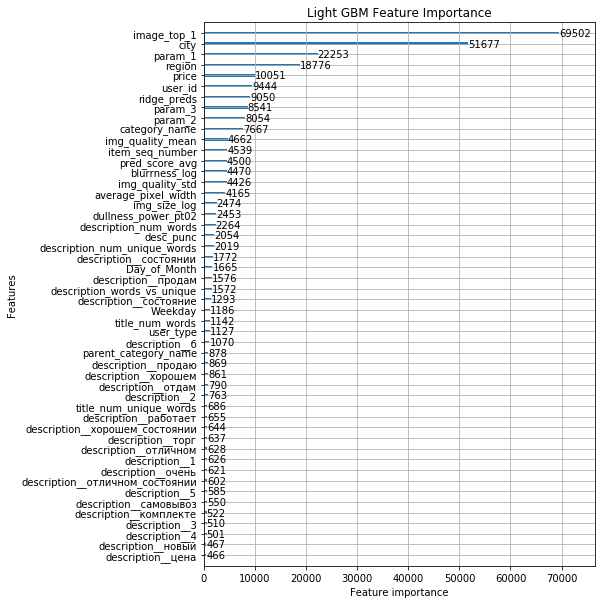

In [57]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.show()

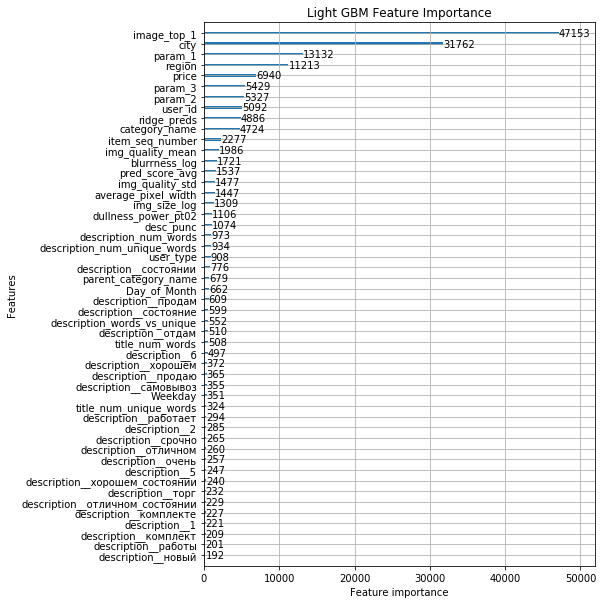

In [33]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.show()

In [60]:
# plt.savefig('feature_importance_by_public_model_stratified.png')

print("Model Evaluation Stage")
lgpred = lgb_clf.predict(testing) 
 
#Mixing lightgbm with ridge. I haven't really tested if this improves the score or not
#blend = 0.95*lgpred + 0.05*ridge_oof_test[:,0]
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub_YEAHYEAHYEAHHHHHHH.csv",index=True,header=True)
#print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))
print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))

Model Evaluation Stage


/home/user/san/project_p/LightGBM/python-package/lightgbm/basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Notebook Runtime: 75.32 Minutes


In [26]:
lgsub.head(100)

,deal_probability
item_id,
6544e41a8817,0.286540
65b9484d670f,0.113667
8bab230b2ecd,0.152080
8e348601fefc,0.114624
8bd2fe400b89,0.285761
c63dbd6c657f,0.057007
6d1a410df86e,0.004078
e8d3e7922b80,0.013810
2bc1ab208462,0.049071
